In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               2627 non-n

In [4]:
train_df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [5]:
train_df.shape, test_df.shape

((8068, 11), (2627, 11))

In [6]:
# Check for missing values
print("Missing values in train set:\n", train_df.isnull().sum())
print("Missing values in test set:\n", test_df.isnull().sum())          

Missing values in train set:
 ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64
Missing values in test set:
 ID                   0
Gender               0
Ever_Married        50
Age                  0
Graduated           24
Profession          38
Work_Experience    269
Spending_Score       0
Family_Size        113
Var_1               32
Segmentation         0
dtype: int64


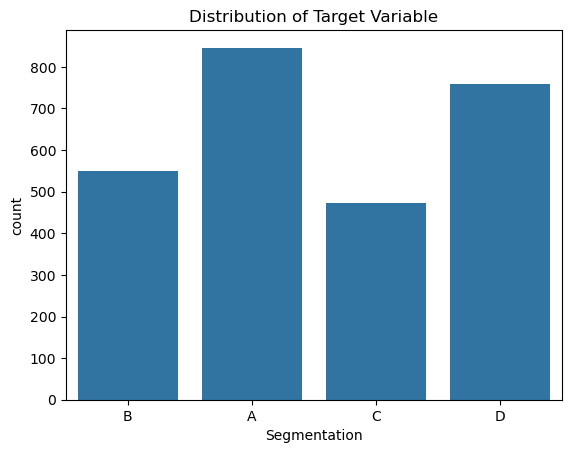

In [7]:
# Visualize the distribution of the target variable
sns.countplot(x='Segmentation', data=test_df)
plt.title('Distribution of Target Variable')
plt.show()  

In [8]:
df = pd.concat([train_df, test_df], ignore_index=True)
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [9]:
df.shape

(10695, 11)

In [10]:
df.isna().sum()

ID                    0
Gender                0
Ever_Married        190
Age                   0
Graduated           102
Profession          162
Work_Experience    1098
Spending_Score        0
Family_Size         448
Var_1               108
Segmentation          0
dtype: int64

In [11]:
# Remplacement des valeurs manquantes
for col in df.columns:
    if df[col].dtype in [np.float64, np.int64]:
        # Pour les colonnes numériques, on utilise la médiane
        median = df[col].median()
        df[col].fillna(median, inplace=True)
    else:
        # Pour les colonnes catégorielles, on utilise la mode
        mode = df[col].mode()[0]
        df[col].fillna(mode, inplace=True)

/var/folders/zl/71xrz48s5c1glhcyx_5gvjqc0000gn/T/ipykernel_23229/989252130.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median, inplace=True)
/var/folders/zl/71xrz48s5c1glhcyx_5gvjqc0000gn/T/ipykernel_23229/989252130.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

In [12]:
df.isnull().sum()

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
dtype: int64

In [13]:
df_num = df.select_dtypes(include=[np.number])
df_cat = df.select_dtypes(exclude=[np.number])

In [14]:
Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75)
IQR = Q3 - Q1
outliers = (df_num < (Q1 - 1.5 * IQR)) | (df_num > (Q3 + 1.5 * IQR))
outlier_counts = outliers.sum()
print("Outlier counts in numerical columns:\n", outlier_counts)

Outlier counts in numerical columns:
 ID                    0
Age                  90
Work_Experience    1536
Family_Size         125
dtype: int64


In [15]:
df.head(20)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,1.0,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,1.0,High,6.0,Cat_6,A
5,461319,Male,Yes,56,No,Artist,0.0,Average,2.0,Cat_6,C
6,460156,Male,No,32,Yes,Healthcare,1.0,Low,3.0,Cat_6,C
7,464347,Female,No,33,Yes,Healthcare,1.0,Low,3.0,Cat_6,D
8,465015,Female,Yes,61,Yes,Engineer,0.0,Low,3.0,Cat_7,D
9,465176,Female,Yes,55,Yes,Artist,1.0,Average,4.0,Cat_6,C


## Séparation de la base de données

In [16]:
X = df.drop(columns=['Segmentation'])
y = df['Segmentation']

In [17]:
X = pd.get_dummies(X, drop_first=True)
X.head()

,ID,Age,Work_Experience,Family_Size,Gender_Male,Ever_Married_Yes,Graduated_Yes,Profession_Doctor,Profession_Engineer,Profession_Entertainment,...,Profession_Lawyer,Profession_Marketing,Spending_Score_High,Spending_Score_Low,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,462809,22,1.0,4.0,True,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False
1,462643,38,1.0,3.0,False,True,True,False,True,False,...,False,False,False,False,False,False,True,False,False,False
2,466315,67,1.0,1.0,False,True,True,False,True,False,...,False,False,False,True,False,False,False,False,True,False
3,461735,67,0.0,2.0,True,True,True,False,False,False,...,True,False,True,False,False,False,False,False,True,False
4,462669,40,1.0,6.0,False,True,True,False,False,True,...,False,False,True,False,False,False,False,False,True,False


In [18]:
#si beaucoup de outliers, utiliser robustscaler
#le plus simple à interpreter: minmax scaler
X_norm = StandardScaler().fit_transform(X)
X_norm=pd.DataFrame(X_norm, columns=X.columns)
X_norm.head(5)

,ID,Age,Work_Experience,Family_Size,Gender_Male,Ever_Married_Yes,Graduated_Yes,Profession_Doctor,Profession_Engineer,Profession_Entertainment,...,Profession_Lawyer,Profession_Marketing,Spending_Score_High,Spending_Score_Low,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,-0.253413,-1.282499,-0.447327,0.764161,0.911604,-1.209608,-1.287814,-0.308607,-0.309514,-0.363793,...,-0.292706,-0.19788,-0.419737,0.804304,-0.235726,-0.3367,2.500169,-0.103798,-1.381529,-0.160627
1,-0.317239,-0.328606,-0.447327,0.099335,-1.096967,0.826714,0.776510,-0.308607,3.230867,-0.363793,...,-0.292706,-0.19788,-0.419737,-1.243311,-0.235726,-0.3367,2.500169,-0.103798,-1.381529,-0.160627
2,1.094610,1.400325,-0.447327,-1.230315,-1.096967,0.826714,0.776510,-0.308607,3.230867,-0.363793,...,-0.292706,-0.19788,-0.419737,0.804304,-0.235726,-0.3367,-0.399973,-0.103798,0.723836,-0.160627
3,-0.666356,1.400325,-0.755089,-0.565490,0.911604,0.826714,0.776510,-0.308607,-0.309514,-0.363793,...,3.416402,-0.19788,2.382442,-1.243311,-0.235726,-0.3367,-0.399973,-0.103798,0.723836,-0.160627
4,-0.307242,-0.209369,-0.447327,2.093811,-1.096967,0.826714,0.776510,-0.308607,-0.309514,2.748818,...,-0.292706,-0.19788,2.382442,-1.243311,-0.235726,-0.3367,-0.399973,-0.103798,0.723836,-0.160627


## Transformation en PCA

In [19]:
pca = PCA().fit(X_norm)

In [20]:
pca.components_

array([[-4.51095239e-03,  4.50730628e-01, -8.18347234e-02,
        -1.41437257e-01,  6.07746959e-02,  4.24736523e-01,
         1.85489752e-01, -6.02874823e-02, -4.03554763e-02,
        -5.11865625e-03,  1.80129685e-01, -3.07423677e-01,
        -2.94462214e-02,  2.68081575e-01, -6.52364840e-02,
         3.44684075e-01, -3.78136729e-01, -9.17301561e-02,
        -8.99283313e-02, -1.18121064e-01, -4.41110971e-02,
         2.14665797e-01, -4.59045625e-02],
       [-7.01283943e-02,  3.71188462e-02,  1.42720784e-01,
        -3.92869172e-01, -1.12774761e-01, -1.81359501e-01,
         2.70265390e-01,  3.95326137e-02, -1.23553924e-01,
         3.00511788e-02, -2.79857386e-01, -3.09947943e-02,
         7.67053743e-02,  7.59733914e-02, -1.68303786e-02,
        -2.41393732e-01,  2.84634801e-01, -1.13700349e-01,
        -1.43084096e-01, -4.12096405e-01, -4.22222418e-02,
         4.89605453e-01, -8.58857347e-02],
       [ 4.40945611e-03, -1.54422248e-01, -5.74529425e-02,
         2.49147674e-01,  4.1

In [21]:
# -- Principal components coefficients (depending on original features)
pca_components = pd.DataFrame(pca.components_,
                      index=['PC'+str(i+1) for i in range(X_norm.shape[1])],
                      columns=X_norm.columns).T
pca_components  #(maths vecteurs propres)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23
ID,-0.004511,-0.070128,0.004409,-0.031854,0.086235,-0.299331,0.227669,-0.177078,-0.253156,0.257466,...,0.074149,-0.172225,0.187396,-0.038425,0.033384,0.016516,-0.018436,0.018197,-0.001648,-0.002992
Age,0.450731,0.037119,-0.154422,-0.114440,-0.219616,0.016579,0.033933,-0.066171,-0.072682,0.048446,...,-0.074283,-0.029356,-0.031040,0.043428,0.167966,-0.208615,0.415747,0.618157,-0.242914,-0.011064
Work_Experience,-0.081835,0.142721,-0.057453,0.198296,0.478823,0.126612,-0.023928,-0.127318,-0.135759,0.114985,...,-0.241208,-0.134091,0.656450,0.134839,0.060152,-0.116128,0.059990,0.069095,-0.020011,-0.004509
Family_Size,-0.141437,-0.392869,0.249148,-0.040469,0.104026,-0.004019,0.035435,0.019443,0.164895,-0.073856,...,0.465624,0.021876,0.147449,0.081037,0.652097,-0.087374,0.058444,0.091625,0.084688,-0.000587
Gender_Male,0.060775,-0.112775,0.415237,0.330106,-0.251877,-0.077557,-0.133450,-0.002520,-0.176328,0.005583,...,-0.266601,-0.024135,-0.054858,0.609973,0.084883,0.337925,-0.037885,0.057732,-0.006658,-0.004326
Ever_Married_Yes,0.424737,-0.181360,-0.115422,0.147080,0.046907,-0.066431,0.012022,-0.010272,0.055791,-0.023961,...,0.129692,0.070733,0.025244,0.303398,-0.215991,-0.370165,0.294151,-0.349266,0.482242,0.007722
Graduated_Yes,0.185490,0.270265,-0.133999,0.285954,0.038853,-0.036334,0.244457,0.020885,0.189732,-0.012493,...,-0.140309,0.628435,0.086966,-0.107893,0.334659,0.270803,0.122875,-0.176696,-0.062842,0.000072
Profession_Doctor,-0.060287,0.039533,-0.042237,0.132564,-0.000214,-0.158857,0.317746,0.668335,-0.336036,-0.161098,...,0.128533,-0.218479,0.076918,-0.058498,-0.038556,0.110397,0.287853,-0.101187,-0.127134,-0.001622
Profession_Engineer,-0.040355,-0.123554,-0.357172,-0.261507,0.222650,-0.280310,-0.139486,-0.020413,0.382583,-0.275691,...,-0.227805,-0.296980,-0.054487,0.238763,0.098197,0.309585,0.241535,-0.135966,-0.137406,-0.003675
Profession_Entertainment,-0.005119,0.030051,-0.016831,0.495663,-0.248868,-0.250664,-0.225390,-0.373183,0.079478,0.094365,...,0.252814,-0.286476,0.036199,-0.347743,-0.011002,0.130650,0.253387,-0.158143,-0.127700,0.000354


In [22]:
print(pca.singular_values_)   #valeurs propres

[185.55102172 142.81235406 129.22337965 119.98032313 117.0796004
 114.52445679 110.65468732 109.359996   106.10566679 105.58534129
 103.88363235 103.7146997  100.6820129   96.93889804  94.47758515
  92.37592871  87.52285919  79.47890352  73.61534469  56.48179454
  52.66057025  49.1666726   17.70062912]


In [23]:
print(pca.explained_variance_ratio_*100) #pourcentage de variance expliquée par chaque composante principale

[13.99645574  8.29130576  6.78849598  5.85209583  5.57254826  5.33197195
  4.97772621  4.86192602  4.57686953  4.5320911   4.38718177  4.37292474
  4.12092921  3.8202126   3.62868228  3.46903763  3.11411301  2.56800053
  2.20306888  1.29690555  1.12735966  0.98272728  0.12737048]


In [24]:
print((pca.explained_variance_ratio_*100).cumsum()) #cumulative explained variance ratio

[ 13.99645574  22.2877615   29.07625749  34.92835332  40.50090158
  45.83287353  50.81059974  55.67252576  60.2493953   64.7814864
  69.16866817  73.54159291  77.66252212  81.48273472  85.111417
  88.58045462  91.69456763  94.26256816  96.46563704  97.76254258
  98.88990224  99.87262952 100.        ]


## PCA

In [25]:
PCA().fit(X_norm)
X_pca = pca.transform(X_norm)

In [26]:
X_projected=pd.DataFrame(X_pca,columns=['PC'+str(i+1) for i in range(X.shape[1])])
X_projected.head(2)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23
0,-3.095230,-1.917972,1.039063,-1.099371,-0.817046,-0.552582,-0.402630,-0.609053,-0.995572,-0.128079,...,-0.247254,1.275453,-0.016323,0.292754,-0.523185,0.313532,0.064155,0.038657,-0.086333,0.037081
1,0.017199,-2.138241,-2.819135,-0.969058,1.010913,-2.047128,-0.264499,-0.153141,1.121168,-0.889172,...,-0.524721,1.176571,-0.176804,0.361751,-0.157758,0.499359,0.066122,-0.784972,-0.545436,0.035589


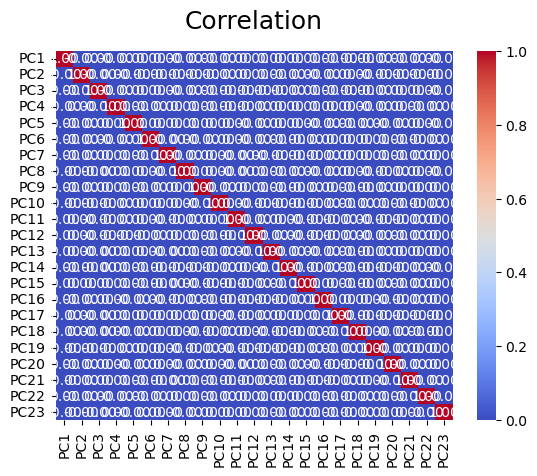

In [27]:
heatmap=sns.heatmap(X_projected.corr(),annot=True, fmt=".2f", cmap='coolwarm')
heatmap.set_title('Correlation', fontdict={'fontsize':18}, pad=16);

<Axes: xlabel='variables'>

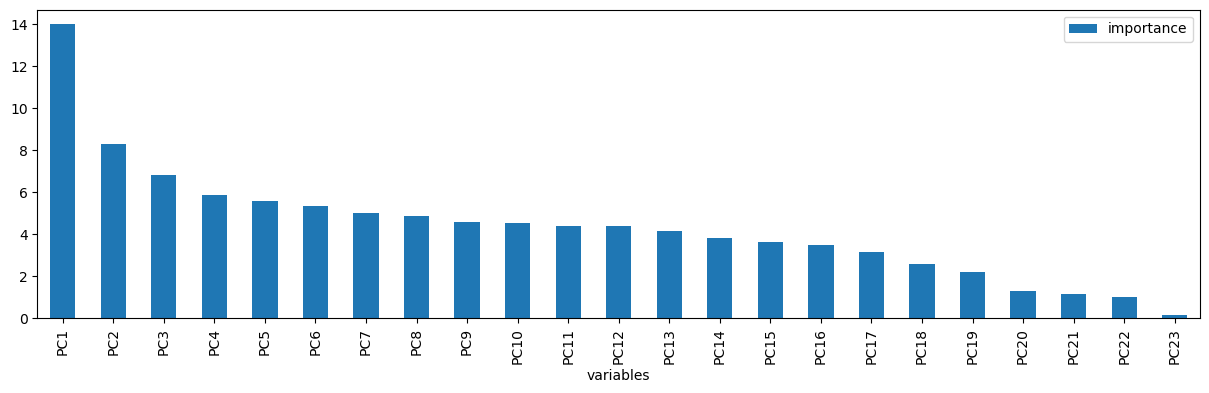

In [28]:
infopca=pd.DataFrame()
infopca["variables"]=['PC'+str(i+1) for i in range(X_norm.shape[1])]
infopca["importance"]=pca.explained_variance_ratio_*100
infopca.set_index("variables", inplace=True)
infopca.plot(kind="bar", figsize=(15,4)) 

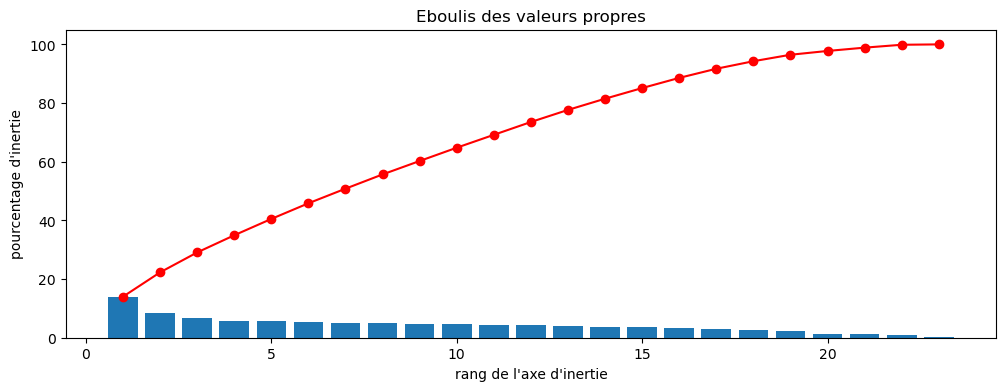

In [29]:
#Variances expliquées
important_degres = pca.explained_variance_ratio_*100
#Projection de l'éboulis des valeurs propres
plt.figure(figsize=(12,4))
plt.bar(np.arange(len(important_degres))+1, important_degres)
plt.plot(np.arange(len(important_degres))+1, important_degres.cumsum(),c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [30]:
# Calcul de la variance cumulée
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Trouver le nombre de composantes nécessaires pour atteindre 95%
n_components_95 = (cumulative_variance < 0.95).sum() + 1
print(f"Nombre de composantes pour 90% de variance : {n_components_95}")

# Sélectionner les colonnes correspondantes dans X_projected
X_pca_95 = X_projected.iloc[:, :n_components_95]
X_pca_95.head()

Nombre de composantes pour 90% de variance : 19


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
0,-3.095230,-1.917972,1.039063,-1.099371,-0.817046,-0.552582,-0.402630,-0.609053,-0.995572,-0.128079,0.466148,0.614024,-0.698306,-0.247254,1.275453,-0.016323,0.292754,-0.523185,0.313532
1,0.017199,-2.138241,-2.819135,-0.969058,1.010913,-2.047128,-0.264499,-0.153141,1.121168,-0.889172,-0.184841,-0.201101,-0.434739,-0.524721,1.176571,-0.176804,0.361751,-0.157758,0.499359
2,0.998413,1.158061,-2.091574,-1.320371,0.632720,-1.652767,-0.059517,-0.252406,1.292936,-0.647818,-0.586180,0.048314,1.447758,-1.065853,-0.645794,-0.574659,0.363527,0.103529,0.038634
3,3.936944,0.209896,0.326361,-1.426217,-1.483175,1.027186,0.313265,-0.312480,-0.441105,-0.079051,0.296400,0.239696,-0.748014,0.134667,0.122688,0.548025,0.347045,0.302303,1.597047
4,1.676130,-0.837611,0.674971,1.058346,0.412103,-0.403787,-0.302907,-0.881216,1.444871,-0.100363,-0.105880,-0.602099,-0.746425,2.689321,-0.153290,0.678691,-2.000596,0.512197,1.168624


## KMEANS

In [31]:
# Appliquer KMeans avec un nombre de clusters égal au nombre de classes de 'Segmentation'
kmeans = KMeans(n_clusters=len(y.unique()), random_state=42)
clusters = kmeans.fit_predict(X_pca_95)

In [32]:
# Attention : les clusters sont arbitraires. On compare via ARI (Adjusted Rand Index)
ari = adjusted_rand_score(y, clusters)
print(f"ARI (Adjusted Rand Index) entre les clusters et la vraie cible : {ari:.2f}")

ARI (Adjusted Rand Index) entre les clusters et la vraie cible : 0.07


In [33]:
# Afficher la prédiction des clusters pour chaque individu
X_pca_95_with_clusters = X_pca_95.copy()
X_pca_95_with_clusters['Cluster'] = clusters
X_pca_95_with_clusters.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,Cluster
0,-3.095230,-1.917972,1.039063,-1.099371,-0.817046,-0.552582,-0.402630,-0.609053,-0.995572,-0.128079,0.466148,0.614024,-0.698306,-0.247254,1.275453,-0.016323,0.292754,-0.523185,0.313532,1
1,0.017199,-2.138241,-2.819135,-0.969058,1.010913,-2.047128,-0.264499,-0.153141,1.121168,-0.889172,-0.184841,-0.201101,-0.434739,-0.524721,1.176571,-0.176804,0.361751,-0.157758,0.499359,0
2,0.998413,1.158061,-2.091574,-1.320371,0.632720,-1.652767,-0.059517,-0.252406,1.292936,-0.647818,-0.586180,0.048314,1.447758,-1.065853,-0.645794,-0.574659,0.363527,0.103529,0.038634,0
3,3.936944,0.209896,0.326361,-1.426217,-1.483175,1.027186,0.313265,-0.312480,-0.441105,-0.079051,0.296400,0.239696,-0.748014,0.134667,0.122688,0.548025,0.347045,0.302303,1.597047,3
4,1.676130,-0.837611,0.674971,1.058346,0.412103,-0.403787,-0.302907,-0.881216,1.444871,-0.100363,-0.105880,-0.602099,-0.746425,2.689321,-0.153290,0.678691,-2.000596,0.512197,1.168624,0


In [34]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

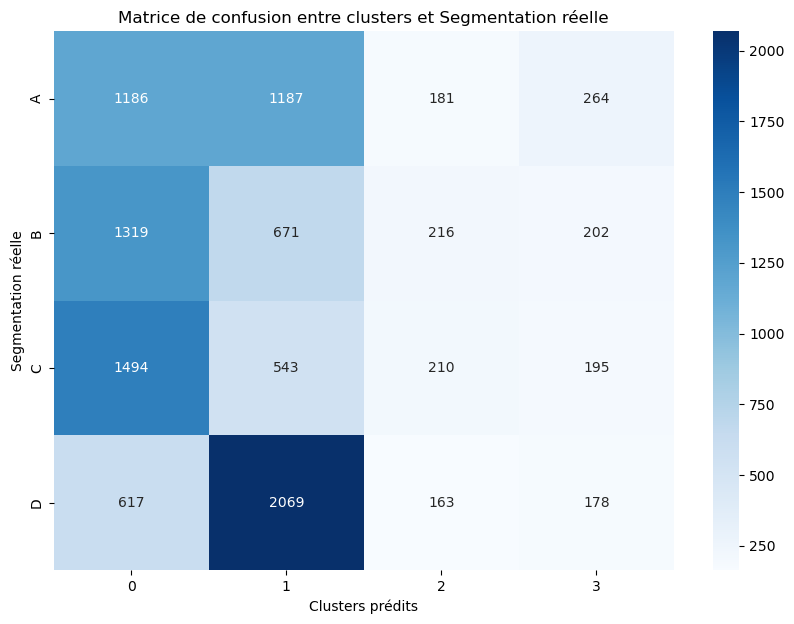

In [35]:
conf_matrix = confusion_matrix(y_encoded, clusters)

# Affichage avec heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(clusters),
            yticklabels=le.classes_)  # Affiche les vraies classes
plt.title("Matrice de confusion entre clusters et Segmentation réelle")
plt.xlabel("Clusters prédits")
plt.ylabel("Segmentation réelle")
plt.show()

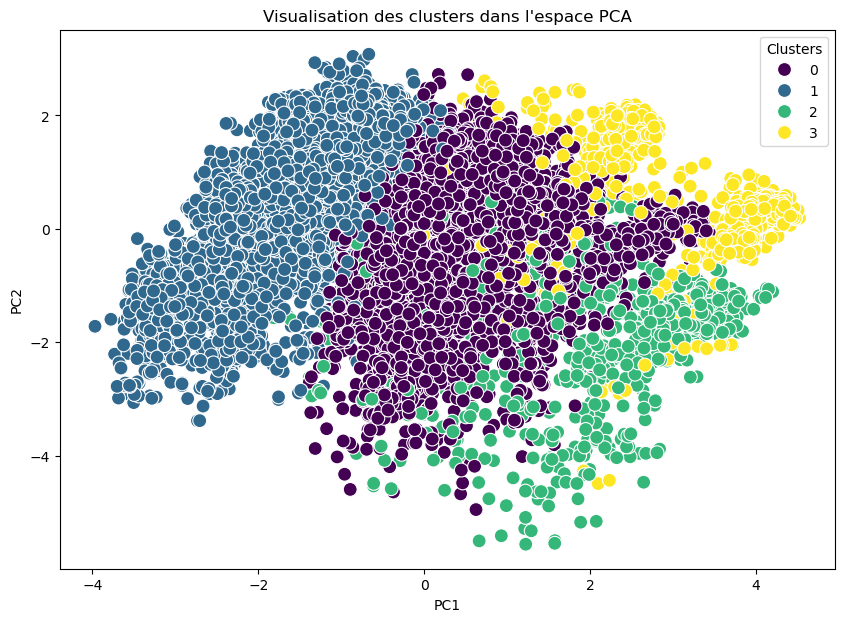

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

In [36]:
# Visualiser les clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca_95['PC1'], y=X_pca_95['PC2'], hue=clusters, palette='viridis', s=100)
plt.title('Visualisation des clusters dans l\'espace PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Clusters')
plt.show()
# Visualiser les clusters avec la vraie segmentation
plt.figure(figsize=(10, 7)) 

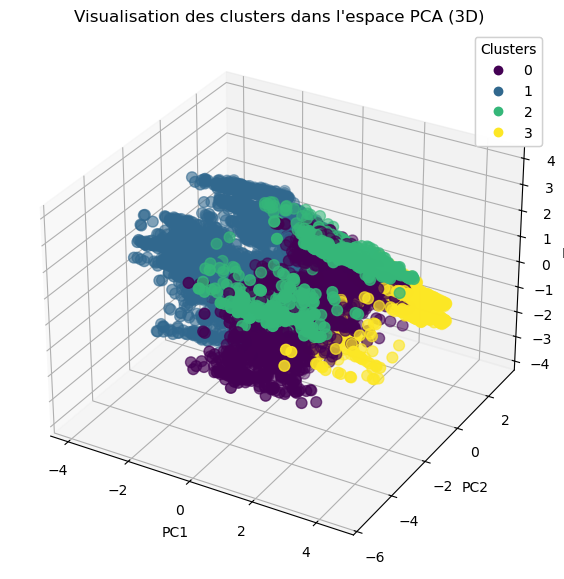

In [37]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    X_pca_95['PC1'], X_pca_95['PC2'], X_pca_95['PC3'],
    c=clusters, cmap='viridis', s=60
)
ax.set_title("Visualisation des clusters dans l'espace PCA (3D)")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.show()

In [38]:
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder

# Encoder y
le = LabelEncoder()
y_encoded = le.fit_transform(y)

models = {
    "KMeans": KMeans(n_clusters=len(np.unique(y)), random_state=42),
    "DBSCAN": DBSCAN(eps=1.5, min_samples=5),
    "Agglomerative": AgglomerativeClustering(n_clusters=len(np.unique(y))),
    "GMM": GaussianMixture(n_components=len(np.unique(y)), random_state=42)
}

for name, model in models.items():
    if name == "GMM":
        clusters = model.fit_predict(X_pca_95)
    else:
        clusters = model.fit(X_pca_95).labels_
    ari = adjusted_rand_score(y_encoded, clusters)
    print(f"{name} ARI : {ari:.3f}")


KMeans ARI : 0.071
DBSCAN ARI : 0.015
Agglomerative ARI : 0.041
GMM ARI : 0.063


## RANDOM FOREST

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

X_train, X_test, y_train, y_test = train_test_split(X_pca_95, y_encoded, test_size=0.2, random_state=42)


In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Prédictions
y_pred = clf.predict(X_test)


In [41]:
print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nClassification report :\n", classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy : 0.4165497896213184

Classification report :
               precision    recall  f1-score   support

           A       0.37      0.35      0.36       584
           B       0.31      0.29      0.30       490
           C       0.41      0.45      0.43       472
           D       0.54      0.55      0.55       593

    accuracy                           0.42      2139
   macro avg       0.41      0.41      0.41      2139
weighted avg       0.41      0.42      0.41      2139



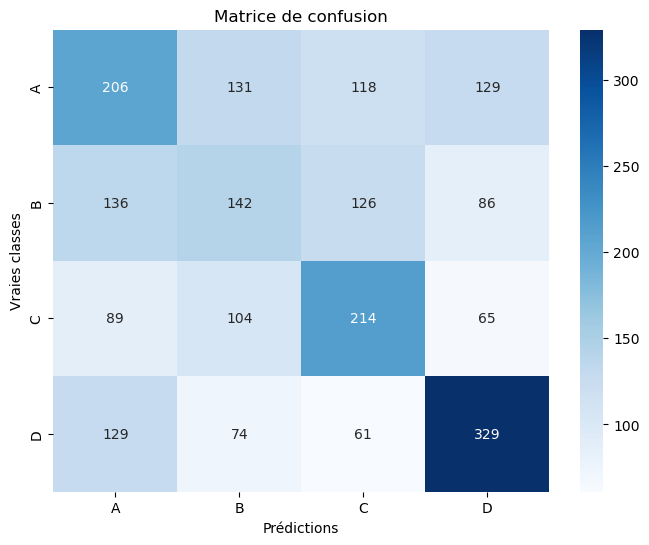

In [42]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de confusion")
plt.show()


## SVM

In [43]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.3f}")


Random Forest Accuracy: 0.417
SVM Accuracy: 0.483
Logistic Regression Accuracy: 0.465
KNN Accuracy: 0.417
